In [40]:
import matplotlib.pyplot as plt
import torch
from torch.quasirandom import SobolEngine
import pandas as pd
import numpy as np
from alse.accuracy import get_accuracy
from alse.utils import identify_samples_which_satisfy_constraints, normalize, unnormalize
from mpl_toolkits import mplot3d
# from matplotlib import cm
# from alse.read_excel import read_excel
from alse.alse import alse
# from alse.generate_test_points import generate_test_points

In [91]:
N1, N2 = 200, 200
Xplt, Yplt = torch.meshgrid(
    torch.linspace(0, 1, N1), torch.linspace(0, 1, N2),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
Xplt, Yplt = torch.meshgrid(
    torch.linspace(600, 1800, N1), torch.linspace(900, 2700, N2),
    indexing='xy',
)

/opt/conda/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [95]:
xplt.shape

torch.Size([40000, 2])

In [42]:
def read_excel(file_path, x_names, y_names):
                                                        # NaN to 0
    consolidated_data = pd.read_excel(f"{file_path}").fillna(0).loc
    # Input parameters
    input_param = []
    for xname in x_names:
        input_param.append(torch.tensor(consolidated_data[:, f"{xname}"]))

    # Output parameters
    output_param = []
    for yname in y_names:
        output_param.append((torch.tensor((consolidated_data[:, f"{yname}"]))).unsqueeze(-1))

    X = torch.stack(tuple(input_param), -1)
    return X, *output_param

    
# X, width, pow_cap, wth = read_excel("/home/jovyan/alse/test_data/8_12_data.xlsx",["V (mm/min)", "P (W)", "spot size (mm)"], ["width (mm)", "powder_cap", "wth"])

X, width, pow_cap, wth = read_excel("/home/jovyan/alse/test_data/8_4_data.xlsx",["V (mm/min)", "P (W)"], ["width (mm)", "powder_cap", "wth"])

In [43]:
bounds = torch.tensor([[600, 900], [1800, 2700]])
constraints = [("gt", 2.5), ("gt", 0.65), ("gt", 6)]

algo = alse(X, bounds, [width, pow_cap, wth], constraints)

algo.initialize_model(["reg", "reg", "reg"])

In [44]:
feasible_inds_width = (
    identify_samples_which_satisfy_constraints(width, constraints[0])
    .prod(dim=-1)
    .to(torch.bool)
)

feasible_inds_pow_cap = (
    identify_samples_which_satisfy_constraints(pow_cap, constraints[1])
    .prod(dim=-1)
    .to(torch.bool)
)

feasible_inds_wth = (
    identify_samples_which_satisfy_constraints(wth, constraints[2])
    .prod(dim=-1)
    .to(torch.bool)
)

/tmp/ipykernel_486191/2790338702.py:25: UserWarning: No contour levels were found within the data range.
  ax[1].contour(Xplt, Yplt, est_pow_cap)


<Figure size 432x288 with 0 Axes>

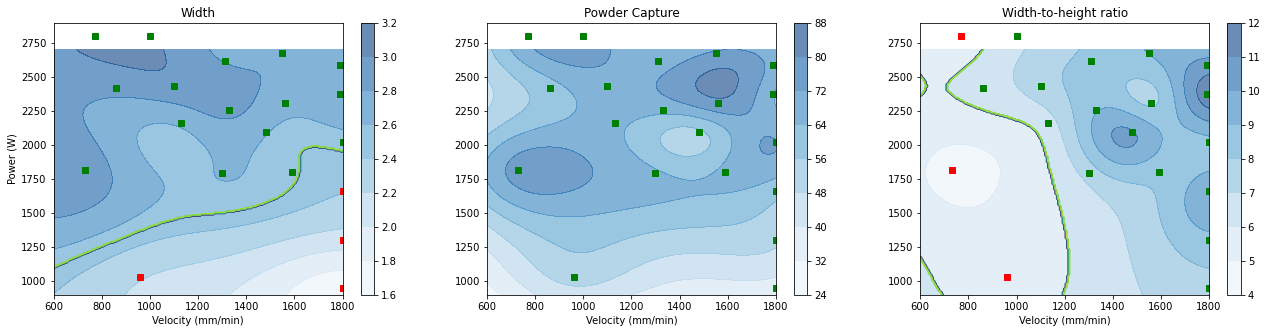

In [45]:
# plt.subplots(3, figsize=(8, 8))
for model in algo.list_of_models:
    model.eval()
predicted_width = algo.list_of_models[0](xplt).loc.detach().reshape(N1,N2)
predicted_pow_cap = algo.list_of_models[1](xplt).loc.detach().reshape(N1,N2)
predicted_wth = algo.list_of_models[2](xplt).loc.detach().reshape(N1,N2)

est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.5
est_wth = predicted_wth > 6

reference = (est_width & est_pow_cap & est_wth)
plt.figure(1)

fig, ax = plt.subplots(1,3, figsize=(22, 5))

plot1 = ax[0].contourf(Xplt, Yplt, predicted_width,cmap="Blues", alpha=0.6)
ax[0].contour(Xplt, Yplt, est_width)
ax[0].plot(X[feasible_inds_width, 0], X[feasible_inds_width, 1], "sg", label="In Boundary")
ax[0].plot(X[~feasible_inds_width, 0], X[~feasible_inds_width, 1], "sr", label="Out of Boundary")
# ax[0].plot(X[-5:, 0], X[-5:, 1], "kx")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].contourf(Xplt, Yplt, predicted_pow_cap,cmap="Blues", alpha=0.6)
ax[1].contour(Xplt, Yplt, est_pow_cap)
# ax[1].contour(Xplt.cpu(), Yplt.cpu(), est_pow_cap2.cpu())
# ax[1].scatter(X.float().numpy()[:, 0], X.float().numpy()[:, 1])
ax[1].plot(X[feasible_inds_pow_cap, 0], X[feasible_inds_pow_cap, 1], "sg", label="In Boundary")
ax[1].plot(X[~feasible_inds_pow_cap, 0], X[~feasible_inds_pow_cap, 1], "sr", label="Out of Boundary")
# ax[1].plot(X[-5:, 0], X[-5:, 1], "kx")
fig.colorbar(plot2, ax=ax[1])

plot3 = ax[2].contourf(Xplt, Yplt, predicted_wth,cmap="Blues", alpha=0.6)
ax[2].contour(Xplt, Yplt, est_wth)
ax[2].plot(X[feasible_inds_wth, 0], X[feasible_inds_wth, 1], "sg", label="In Boundary")
ax[2].plot(X[~feasible_inds_wth, 0], X[~feasible_inds_wth, 1], "sr", label="Out of Boundary")
# ax[2].plot(X[-5:, 0], X[-5:, 1], "kx")
fig.colorbar(plot3, ax=ax[2])
# ax[0].contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu())

# plt.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(), cmap="Blues", alpha=0.6)
ax[0].set_xlabel('Velocity (mm/min)')
ax[1].set_xlabel('Velocity (mm/min)')
ax[2].set_xlabel('Velocity (mm/min)')
ax[0].set_ylabel('Power (W)')
ax[0].set_title('Width')
ax[1].set_title('Powder Capture')
ax[2].set_title('Width-to-height ratio')



plt.show()

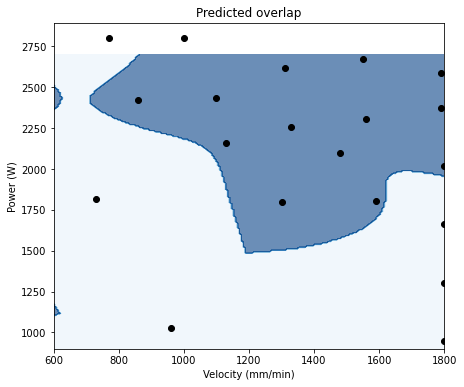

In [46]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(),cmap="Blues", alpha=0.6)
ax.scatter(X[:, 0], X[:, 1], color='k')
ax.set_title('Predicted overlap')
ax.set_ylabel('Power (W)')
ax.set_xlabel('Velocity (mm/min)')
plt.show()

In [89]:
X, width, pow_cap, wth = read_excel("/home/jovyan/alse/test_data/8_4_data_update.xlsx",["V (mm/min)", "P (W)"], ["width (mm)", "powder_cap", "wth"])

test_width = width > 2.5
test_pow_cap = pow_cap > 0.5
test_wth = wth > 6

y = (test_width & test_pow_cap & test_wth).squeeze()
y_old = y[:-4]
X_old = X[:-4]
y_new = y[-4:]
X_new = X[-4:]
print(test.squeeze())

tensor([False, False, False, False])


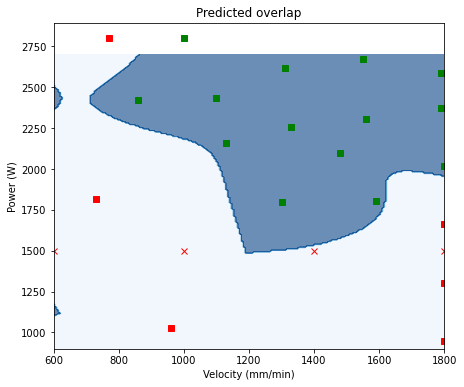

In [90]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(),cmap="Blues", alpha=0.6)
ax.plot(X_old[y_old, 0], X_old[y_old, 1], "sg", label="In Boundary")
ax.plot(X_old[~y_old, 0], X_old[~y_old, 1], "sr", label="Out of Boundary")

ax.plot(X_new[y_new, 0], X_new[y_new, 1], "xg", label="In Boundary")
ax.plot(X_new[~y_new, 0], X_new[~y_new, 1], "xr", label="Out of Boundary")
ax.set_title('Predicted overlap')
ax.set_ylabel('Power (W)')
ax.set_xlabel('Velocity (mm/min)')
plt.show()